In [8]:
# !/usr/bin/env python3
import argparse
import datetime as dt
import json
import multiprocessing
import os
import time
import traceback

import nevergrad as ng
import numpy as np
import pandas as pd
import seaborn as sns
import pcse
import plotly.graph_objs as go
import yaml
from dateutil.relativedelta import relativedelta
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.engine import Engine
from pcse.fileinput import CABOFileReader, YAMLCropDataProvider
from pcse.models import Wofost71_PP, Wofost71_WLP_FD
from PIL import Image
from plotly.subplots import make_subplots
import logging



import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sys
sys.path.append('../')
from src.weather import AwsNasaPower, AWS_WOFOST

sns.set_context('talk')

class Irrigation:
    """
    Update: Class for all crop simulations with WOFOST model


    Class for irrigation optimization

    input: np.array of days and ammount of water

    Example: [12,45,43] - days
             [13,23,23] - water in sm
             np.np.concatenate(days, water)
    output: float (yield)

    """
    # myFmt = mdates.DateFormatter('%d')

    def __init__(self):

        self.date_crop_start = None
        self.date_crop_end = None
        self.range_irrigation_season = []
        self.optimal_dates_irrigation = None
        self.user_language = "EN"
        # path to soil dats
        self.data_dir = os.path.join(os.getcwd(), "data")
        self.weather = None
        self.myFmt = mdates.DateFormatter('%b')
        self.user_parameters = {
            "name": "Sugar-beet",
            "latitude": 52.057762,
            "longitude": 29.824742,
            "crop_start": "2018-05-10",
            "crop_end": "2018-09-15",
            "crop_name": "sugarbeet",
            "irrigation_events": ["2018-05-21"],
            "irrigation_ammounts": [10],
            "npk_events": [],
            "npk": [],
        }
        self.path_to_CSV_database = "./input_data/weather/"
        self.crop_data_providers = YAMLCropDataProvider(fpath='../db/crop_parameters/')
        self._csv_weather_database_boarders = {
            "latitude_min": 10,
            "latitude_max": 90,
            "longitude_min": 10,
            "longitude_max": 160,
        }
        self.user_titles = {"TWSO":"Crop Yield, kg/ha", 
                        "LAI": "Leaf Area Index", 
                        "SM": "Soil Moisture, %"}
        self.color_vars = {"TWSO":sns.color_palette('PiYG_r')[0], 
                        "LAI": sns.color_palette(palette='pastel')[3], 
                        "SM": sns.color_palette(palette='pastel')[0]}    
    def round_geoposition(self, x, prec=1, base=0.5):
        return round(base * round(float(x) / base), prec)

    def irrigation(self, x):
        """
        np.array with dates and amounts of water

        Ex.: [31, 42, 54, 10, 15, 16]

        """
        assert len(x) % 2 == 0, "not symmetric"
        half = len(x) // 2
        dates = x[:half]
        amounts = x[half:]
        local_range = pd.date_range(start=self.date_crop_start, end=self.date_crop_end)
        dates_of_irrigation = [str(local_range[date])[:10] for date in dates]
        ammounts_of_irrigation = amounts
        return dates_of_irrigation, ammounts_of_irrigation

    def load_model(self):
        """
        Function to load input soil, site and
        crop parameters data from yaml files
        """
        
        crop =self.crop_data_providers
        soil = CABOFileReader(os.path.join(self.data_dir, "wofost_npk.soil"))
        site = CABOFileReader(os.path.join(self.data_dir, "wofost_npk.site"))
        # site["CO2"] = 360.0
        self.parameterprovider = ParameterProvider(
            soildata=soil, cropdata=crop, sitedata=site
        )

    def run_simulation_manager(self, agromanagement):
        """
        Run crop yield simulation based on agromanagment

        Out: crop yield
        """
        if self.user_parameters["crop_name"] == "rice":
            wofost = Wofost71_PP(self.parameterprovider, self.weather, agromanagement)
        else:
            wofost = Wofost71_WLP_FD(
                self.parameterprovider, self.weather, agromanagement
            )
        wofost.run_till_terminate()
        self.output = wofost.get_output()
        return self.output[-1]["TWSO"]


    def agromanager_writer(
        self, crop_name, dates_irrigation, dates_npk, amounts, npk_list
    ):
        """
        Fun to add new irrigation events in agrocalendar

        Input: dates - list of date in str format (ex. 2006-07-10)
            amounts - list of water mm in str format (ex. '10')

        Example: #add example

        """

        self.date_start = (
            dt.datetime.strptime(self.date_crop_start, "%Y-%m-%d")
            - dt.timedelta(days=2)
        ).strftime(format="%Y-%m-%d")

        dict_of_crop_sorts = {
            "barley": "Spring_barley_301",
            "cassava": "Cassava_VanHeemst_1988",
            "chickpea": "Chickpea_VanHeemst_1988",
            "cotton": "Cotton_VanHeemst_1988",
            "cowpea": "Cowpea_VanHeemst_1988",
            "fababean": "Faba_bean_801",
            "groundnut": "Groundnut_VanHeemst_1988",
            "maize": "Maize_VanHeemst_1988",
            "millet": "Millet_VanHeemst_1988",
            "mungbean": "Mungbean_VanHeemst_1988",
            "pigeonpea": "Pigeonpea_VanHeemst_1988",
            "potato": "Potato_701",
            "rapeseed": "Oilseed_rape_1001",
            "rice": "Rice_501",
            "sorghum": "Sorghum_VanHeemst_1988",
            "soybean": "Soybean_901",
            "sugarbeet": "Sugarbeet_601",
            "sugarcane": "Sugarcane_VanHeemst_1988",
            "sunflower": "Sunflower_1101",
            "sweetpotato": "Sweetpotato_VanHeemst_1988",
            "tobacco": "Tobacco_VanHeemst_1988",
            "wheat": "Winter_wheat_101",
        }
        
        sort_name = dict_of_crop_sorts[str(crop_name)]

        crop_data = {
            "start_moment": self.date_start,
            "crop_name": crop_name,
            "crop_full_name": sort_name,
            "crop_start_date": self.date_crop_start,
            "crop_end_date": self.date_crop_end,
            "events_irrigation": [],
            "events_npk": [],
        }
        if len(set(dates_irrigation)) != len(dates_irrigation):
            dates_irrigation = list(set(dates_irrigation))
            amounts = amounts[: len(set(dates_irrigation))]

        if len(set(dates_npk)) != len(dates_npk):
            dates_npk = list(set(dates_npk))
            amounts = amounts[: len(set(dates_npk))]

        crop_data["events_irrigation"] = [
            {date: amount for (date, amount) in zip(dates_irrigation, amounts)}
        ]

        crop_data["events_npk"] = [
            {date: npk for (date, npk) in zip(dates_npk, npk_list)}
        ]

        template = """        
- 2000-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_601
        crop_start_date: 2000-02-02
        crop_start_type: emergence
        crop_end_date: 2000-03-03
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    -   event_signal: irrigate
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table: 
        - 2018-07-07: {amount: 10, efficiency: 0.7}
    -   event_signal: apply_npk
        name:  Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - 2000-01-10: {N_amount : 10, P_amount: 5, K_amount: 2}
    StateEvents: null"""

        crop_start = yaml.safe_load(crop_data["crop_start_date"])
        crop_end = yaml.safe_load(crop_data["crop_end_date"])

        agromanag = yaml.safe_load(template)
        agromanag[0][crop_start - dt.timedelta(days=2)] = agromanag[0].pop(
            dt.date(2000, 1, 1)
        )
        x = list(agromanag[0].items())[0][0]
        agromanag[0][x]["CropCalendar"]["crop_name"] = crop_name
        agromanag[0][x]["CropCalendar"]["variety_name"] = sort_name
        agromanag[0][x]["CropCalendar"]["crop_start_date"] = crop_start
        agromanag[0][x]["CropCalendar"]["crop_end_date"] = crop_end
        agromanag[0][x]["TimedEvents"][0]["events_table"].clear()
        agromanag[0][x]["TimedEvents"][1]["events_table"].clear()

        if bool(crop_data["events_irrigation"][0]):
            for date, amount in zip(dates_irrigation, amounts):
                agromanag[0][x]["TimedEvents"][0]["events_table"].append(
                    {yaml.safe_load(date): {"amount": int(amount), "efficiency": 0.7}}
                )
            if bool(crop_data["events_npk"][0]):
                for date, npk in zip(dates_npk, npk_list):
                    agromanag[0][x]["TimedEvents"][1]["events_table"].append(
                        {
                            yaml.safe_load(date): {
                                "N_amount": npk[0],
                                "P_amount": npk[1],
                                "K_amount": npk[2],
                                "N_recovery": 0.7,
                                "P_recovery": 0.7,
                                "K_recovery": 0.7,
                            }
                        }
                    )
            else:
                agromanag[0][x]["TimedEvents"].pop()
        else:
            agromanag[0][x]["TimedEvents"] = None
        return agromanag

    def crop_hpc(self, year) -> pd.DataFrame:
        self.date_crop_start = self.year_changer(
            self.user_parameters["crop_start"], year
        )
        self.date_crop_end = self.year_changer(self.user_parameters["crop_end"], year)

        dates_irrigation, amounts = (
            self.user_parameters["irrigation_events"],
            self.user_parameters["irrigation_ammounts"],
        )
        dates_irrigation = [self.year_changer(obj, year) for obj in dates_irrigation]

        dates_npk, npk_list = (
            self.user_parameters["npk_events"],
            self.user_parameters["npk"],
        )
        dates_npk = [self.year_changer(obj, year) for obj in dates_npk]
        agromanagement = self.agromanager_writer(
            self.user_parameters["crop_name"],
            dates_irrigation,
            dates_npk,
            amounts,
            npk_list,
        )

        self.load_model()
        self.run_simulation_manager(agromanagement)
        output = pd.DataFrame(self.output).set_index("day")
        return output
    


    def year_changer(self, obj, year):

        """
        Util function to change user year to new year


        Input: str - date event in format '%Y-%m-%d'

        Output: str - new date event in format '%Y-%m-%d'

        """
        type_of_dt = "%Y-%m-%d"
        year_delta = int(self.user_parameters["crop_end"][:4]) - year

        dt_date_crop_start = dt.datetime.strptime(obj, type_of_dt) - relativedelta(
            years=year_delta
        )
        updated_date = dt.datetime.strftime(dt_date_crop_start, type_of_dt)

        return updated_date

    



    def getBarPlot(self, df, ax, cmap):
        rank = df["yield"].argsort().argsort() 
        pal = sns.color_palette(cmap, len(df))
        g=sns.barplot(x='date',y='yield',data=df,edgecolor='black',
                    palette=np.array(pal[::-1])[rank], ax=ax)
        df = df.reset_index(drop=True)
        ax.set_xlabel('Year', fontdict={'fontsize':16})
        ax.set_ylabel('Crop yield, kg/ha', fontdict={'fontsize':16})
        ax.grid()
        ax.set_axisbelow(True)
        return ax


    def sowing_date(self, sowing_date):
        """
        Function to define best day for sowing crop for one year
        Code writes crop yields data into list
        """
        td = dt.timedelta(days=1)
        year = self.NASA_last_year
        self.date_crop_start = dt.datetime.strftime(
            dt.datetime.strptime(
                self.year_changer(self.user_parameters["crop_start"], year), "%Y-%m-%d"
            )
            + sowing_date * td,
            "%Y-%m-%d",
        )
        self.date_crop_end = self.year_changer(self.user_parameters["crop_end"], year)

        dates_irrigation, amounts = (
            self.user_parameters["irrigation_events"],
            self.user_parameters["irrigation_ammounts"],
        )
        dates_irrigation = [self.year_changer(obj, year) for obj in dates_irrigation]

        dates_npk, npk_list = (
            self.user_parameters["npk_events"],
            self.user_parameters["npk"],
        )
        dates_npk = [self.year_changer(obj, year) for obj in dates_npk]

        agromanagement = self.agromanager_writer(
            self.user_parameters["crop_name"],
            dates_irrigation,
            dates_npk,
            amounts,
            npk_list,
        )

        self.load_model()
        self.run_simulation_manager(agromanagement)
        return [self.date_crop_start, self.run_simulation_manager(agromanagement)]



    def dynamic_plotting(self, crop_result: pd.DataFrame, output_fname):
        
        for var, name in self.user_titles.items():
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    
            sns.lineplot(data = crop_result, x='day',
                        y=var, color = self.color_vars[var],
                        linewidth=5,ax=ax)
            ax.grid()
            ax.set_ylabel('')
            ax.xaxis.set_major_formatter(self.myFmt)
            ax.set_xlabel('')
            ax.fill_between(crop_result.index.values,
                            crop_result[var].values,
                            alpha = 0.3,
                            color = self.color_vars[var])
            ax.set_ylim(crop_result[var].min(), crop_result[var].max()*1.05)
            ax.set_title(name)
            ax.patch.set_facecolor('white')
            body = os.path.splitext(output_fname)[0]
            new_name = f'{body}_{var}.png'
            fig.savefig(new_name, transparent=False, dpi=300)

    def plot_historical(self, crop_results:list, output_fname:str):
        historical_yield = pd.DataFrame(
            data=np.zeros([len(crop_results), 2]), columns=["date", "yield"]
        )
        dates = [crop.index[-1].year for crop in crop_results]
        values = [crop['TWSO'][-1] for crop in crop_results]
        historical_yield = pd.DataFrame(data={'date':dates, "yield":values})

        fig, ax = plt.subplots(1,1, figsize=(12,6))
        ax = self.getBarPlot(historical_yield, ax, 'PiYG_r')
        ax.xaxis.set_tick_params(rotation=15)
        body = os.path.splitext(output_fname)[0]
        new_name = f'{body}_historical_yield.png'
        fig.savefig(new_name, dpi=300, bbox_inches='tight')
    def plot_sowing_dates(self, sowing_date_df, output_fname:str):

        fig, ax = plt.subplots(1,1, figsize=(12,6))
        ax = self.getBarPlot(sowing_date_df, ax, 'YlOrBr')
        ax.xaxis.set_tick_params(rotation=45)
        body = os.path.splitext(output_fname)[0]
        new_name = f'{body}_sowing_dates.png'
        fig.savefig(new_name, dpi=300, bbox_inches='tight')


    def compute(
        self,
        path_to_data_dir: str,
        path_to_user_file: str,
        output_plot_name: str,
        weather: AWS_WOFOST,
    )->dict:

        try:
            msg = f"path_to_user_file: {path_to_user_file}"
            logger.info(msg)
            print(msg)
            with open(path_to_user_file, "r") as f:
                self.user_parameters = json.load(f)

            self.user_language = "EN"
            # self.weather_loader_updated(path_to_CSV_weather, latitude, longitude)
            self.weather = weather
            self.NASA_start_year = weather.first_date.year + 1  # type: ignore
            self.NASA_last_year = weather.last_date.year - 1  # type: ignore
            self.data_dir = path_to_data_dir

            sowing_range = range(-7, 7)
            sowing_date_df = pd.DataFrame(  
                data=np.zeros([len(sowing_range), 2]), columns=["date", "yield"]
            )
            sowing_date_results = []
            for sowing_date in sowing_range:
                sowing_date_results.append(self.sowing_date(sowing_date))

            for index, yield_data in enumerate(sowing_date_results):
                sowing_date_df.iloc[index, :] = (yield_data[0], yield_data[1]) # type: ignore
            self.sowing_date_df = sowing_date_df
            crop_results=[]
            inputs = np.arange(self.NASA_last_year-10, self.NASA_last_year, step=1)
            for year in inputs:
                year_yield=self.crop_hpc(year)
                crop_results.append(year_yield)

            self._crop_results = crop_results
            print("Start plotting")
            self.dynamic_plotting(crop_result=self._crop_results[-1],
                output_fname=output_plot_name)
            self.plot_historical(crop_results=crop_results, output_fname=output_plot_name)
            self.plot_sowing_dates(sowing_date_df=sowing_date_df, output_fname=output_plot_name)
            print("Okey! We have not problems")
            info = "Okey! We have not problems"
            content={"status": "Success", "info": info}
            return content
        except Exception:
            info = traceback.format_exc()
            content={"status": "Error", "info": info}
            return content


In [2]:
with open("user_data.json", "r") as f:
    user_parameters = json.load(f)

In [9]:
aws = AwsNasaPower()

In [10]:
import json
with open("user_data.json", "r") as f:
    user_parameters = json.load(f)

user_parameters['latitude']

wdp = AWS_WOFOST(latitude=user_parameters['latitude'], 
                longitude=user_parameters['longitude'],
                ds_solar=aws.ds_solar,
                ds_weather=aws.ds_weather)

start weather selection
done weather selection
start loading to pandas
Finish loading to pandas


YAMLCropDataProvider - Failed to load cache file: [Errno 2] No such file or directory: 'barley'
path_to_user_file: user_data.json
Start plotting
Okey! We have not problems


{'status': 'Success', 'info': 'Okey! We have not problems'}

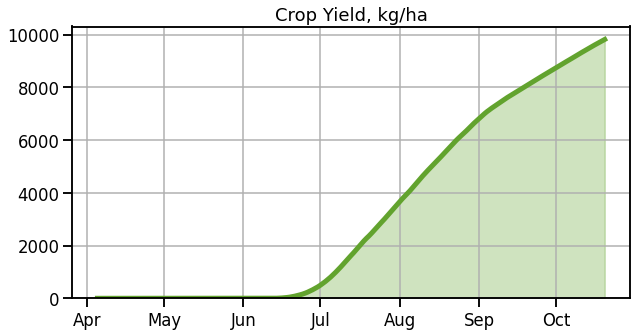

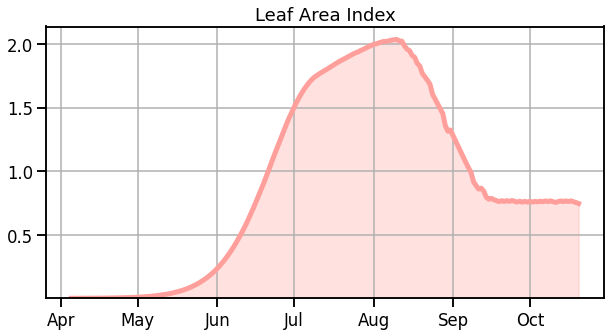

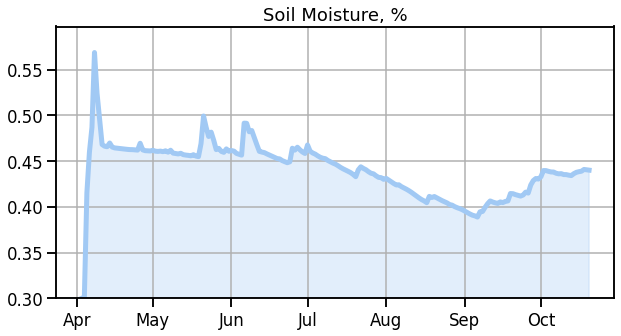

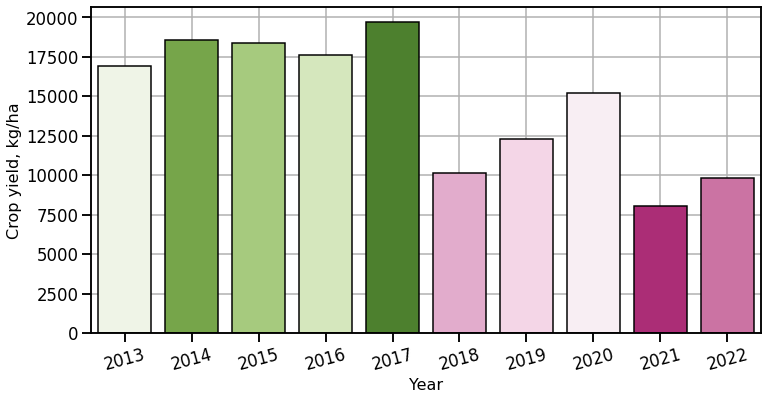

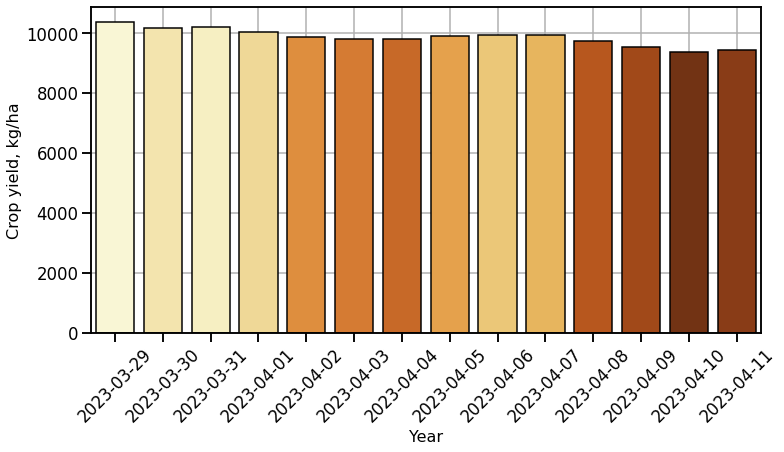

In [11]:

logging.basicConfig(
    format=(
        "%(asctime)s, %(levelname)-8s"
        "[%(filename)s:%(module)s:%(funcName)s:%(lineno)d] %(message)s"
    ),
    datefmt="%Y-%m-%d:%H:%M:%S",
    level=logging.INFO,
)

logger = logging.getLogger(__name__)

WOFOST = Irrigation()
WOFOST.compute(
        path_to_data_dir="../src/input_data", 
        path_to_user_file="user_data.json",
        output_plot_name="result.png",
        weather=wdp)


In [9]:
crop_result = WOFOST._crop_results[-1]

In [10]:
color_yield = sns.color_palette('PiYG_r')[0]

In [11]:
crop_result.index

Index([2022-04-03, 2022-04-04, 2022-04-05, 2022-04-06, 2022-04-07, 2022-04-08,
       2022-04-09, 2022-04-10, 2022-04-11, 2022-04-12,
       ...
       2022-10-11, 2022-10-12, 2022-10-13, 2022-10-14, 2022-10-15, 2022-10-16,
       2022-10-17, 2022-10-18, 2022-10-19, 2022-10-20],
      dtype='object', name='day', length=201)

In [27]:
output_fname  ='result.png'
var
body = os.path.splitext(output_fname)[0]
new_name = f'{body}_{var}.png'


In [28]:
new_name

'result_SM.png'

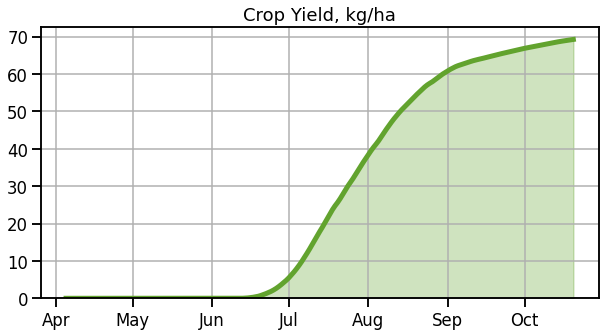

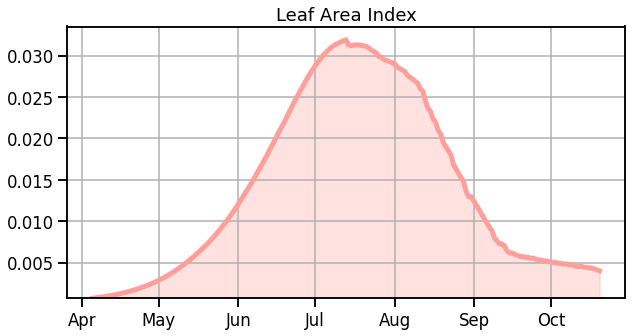

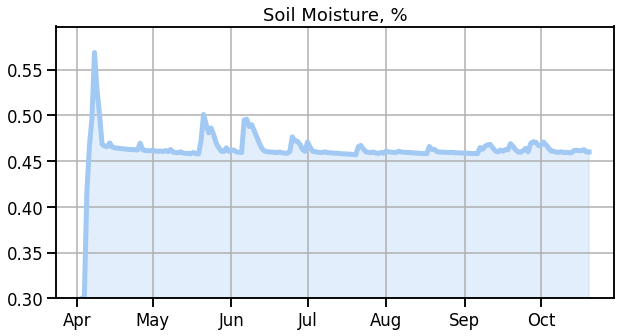

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d')
myFmt = mdates.DateFormatter('%b')
import seaborn as sns
sns.set_context('talk')

user_titles = {"TWSO":"Crop Yield, kg/ha", 
                "LAI": "Leaf Area Index", 
                "SM": "Soil Moisture, %"}
color_vars = {"TWSO":sns.color_palette('PiYG_r')[0], 
                "LAI": sns.color_palette(palette='pastel')[3], 
                "SM": sns.color_palette(palette='pastel')[0]}
# for var, ax in zip(["TWSO", "TAGP", "LAI", "SM"], axes.flatten()):
for var, name in user_titles.items():
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    # ax.plot_date(crop_result.index, crop_result[var], 'b-')
    sns.lineplot(data = crop_result, x='day',
                y=var, color = color_vars[var],
                linewidth=5,ax=ax)
    ax.grid()
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlabel('')
    ax.fill_between(crop_result.index.values,
                    crop_result[var].values,
                    alpha = 0.3,
                    color = color_vars[var])
    ax.set_ylim(crop_result[var].min(), crop_result[var].max()*1.05)
    ax.set_title(name)
    plt.savefig(f'./plots/{var}.png', dpi=300)
    plt.show()
# fig.autofmt_xdate()

In [20]:
crop_results = WOFOST._crop_results
historical_yield = pd.DataFrame(
    data=np.zeros([len(crop_results), 2]), columns=["date", "yield"]
)
dates = [crop.index[-1].year for crop in crop_results]
values = [crop['TWSO'][-1] for crop in crop_results]
historical_yield = pd.DataFrame(data={'date':dates, "yield":values})


NameError: name 'historical_yield' is not defined

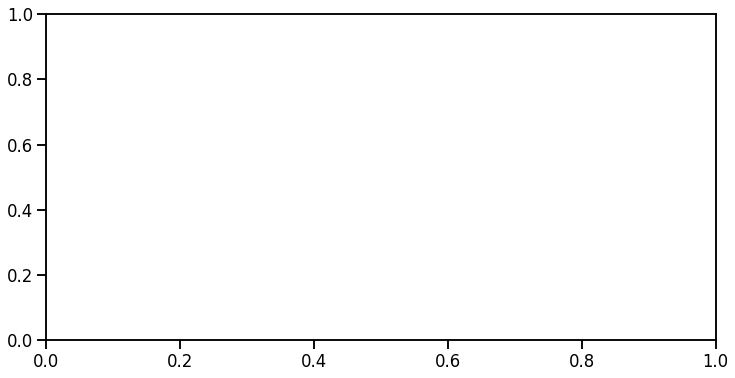

In [19]:

import matplotlib.dates as mdates
# plt.style.use(['science','no-latex'])
fig, ax = plt.subplots(1,1, figsize=(12,6))



def getBarPlot(df, ax, cmap):
    rank = df["yield"].argsort().argsort() 
    pal = sns.color_palette(cmap, len(df))
    g=sns.barplot(x='date',y='yield',data=df,edgecolor='black',
                   palette=np.array(pal[::-1])[rank], ax=ax)
    df = df.reset_index(drop=True)
    ax.set_xlabel('Year', fontdict={'fontsize':16})
    ax.set_ylabel('Crop yield, kg/ha', fontdict={'fontsize':16})
    ax.grid()
    ax.set_axisbelow(True)
    return ax

ax = getBarPlot(historical_yield, ax, 'PiYG_r')
ax.xaxis.set_tick_params(rotation=15)
# plt.savefig('./plots/historical_yield.png', dpi=300, bbox_inches='tight')
plt.show()

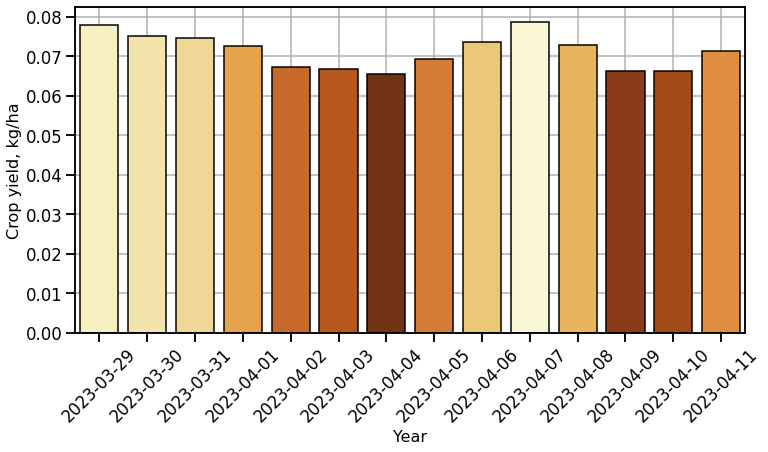

In [18]:
import matplotlib.dates as mdates
# plt.style.use(['science','no-latex'])
fig, ax = plt.subplots(1,1, figsize=(12,6))



def getBarPlot(df, ax, cmap):
    rank = df["yield"].argsort().argsort() 
    pal = sns.color_palette(cmap, len(df))
    g=sns.barplot(x='date',y='yield',data=df,edgecolor='black',
                   palette=np.array(pal[::-1])[rank], ax=ax)
    df = df.reset_index(drop=True)
    ax.set_xlabel('Year', fontdict={'fontsize':16})
    ax.set_ylabel('Crop yield, kg/ha', fontdict={'fontsize':16})
    ax.grid()
    ax.set_axisbelow(True)
    
    return ax

ax = getBarPlot(WOFOST.sowing_date_df, ax, 'YlOrBr')
ax.xaxis.set_tick_params(rotation=45)
plt.show()

In [141]:
data=WOFOST.weather.export()

In [142]:
weather = pd.DataFrame(data)

In [144]:
weather.to_csv('~/Downloads/example_weather.csv')

/Users/mikhailgasanov/geo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='day', ylabel='SM'>

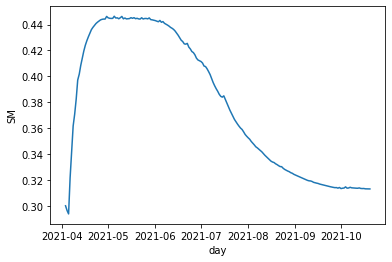

In [106]:
import seaborn as sns
sns.lineplot(crop_result.index, crop_result[var])

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for var, ax in zip(["TWSO", "TAGP", "LAI", "SM"], axes.flatten()):
    ax.plot_date(crop_result.index, crop_result[var], 'b-')
    ax.set_title(var)
fig.autofmt_xdate()